# 3D Reconstruction RGB

### Imports

In [7]:
import cv2
import numpy as np
import plotly.offline
from PIL import Image
import tensorflow as tf
from pathlib import Path
import keras.backend as K
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from keras.models import load_model
import keras.utils.conv_utils as conv_utils
from tensorflow.keras.layers import Layer, InputSpec

### UpSample2D & Predict

In [8]:
class UpSample2D(Layer):
    def __init__(self, size=(2, 2), data_format=None, **kwargs):
        super(UpSample2D, self).__init__(**kwargs)
        self.data_format = data_format.lower()
        self.size = conv_utils.normalize_tuple(size, 2, 'size')
        self.input_spec = InputSpec(ndim=4)

    def call(self, inputs):
        in_shape = K.shape(inputs)
        if self.data_format == 'channels_first':
            height = self.size[0] * in_shape[2] if in_shape[2] is not None else None
            width = self.size[1] * in_shape[3] if in_shape[3] is not None else None
        elif self.data_format == 'channels_last':
            height = self.size[0] * in_shape[1] if in_shape[1] is not None else None
            width = self.size[1] * in_shape[2] if in_shape[2] is not None else None
        
        return tf.image.resize(inputs, [height, width], method=tf.image.ResizeMethod.BILINEAR)

def predict(model, img: np.ndarray) -> np.ndarray:        
    img = np.clip(np.asarray(img, dtype=float) / 255, 0, 1)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    pred = model.predict(img, batch_size=1)[0]
    depth_norm_cm =  10 / pred
    return depth_norm_cm

def box_distance(d_img: np.ndarray)-> float:
    box_h, box_w = int(d_img.shape[0] / 10),  int(d_img.shape[1] / 2) - 5
    return np.mean(d_img[box_h:box_h+10, box_w:box_w+10])

### Load model

In [9]:
model = load_model('./models/nyu.h5',custom_objects = {'BilinearUpSampling2D': UpSample2D, 'depth_loss_function': None}, compile=False)

### Predict

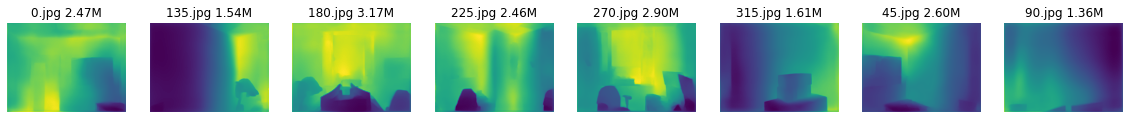

In [10]:
static = Path('./images/').glob('*.jpg')
f = plt.figure(figsize=(20, 5))
res = []

for idx, img in enumerate(static, start=1):
    o_img=np.array(Image.open(str(img)).resize((640,480)))
    d_img=predict(model, o_img)
    d_box=box_distance(d_img)
    res.append({'ang': int(img.name.split('.')[0]), 'dis':d_box})
    f.add_subplot(1, 8, idx), plt.axis('off'), plt.title('{} {}M'.format(img.name, '%.2f' % (d_box))), plt.imshow(d_img)

### Indoor2D

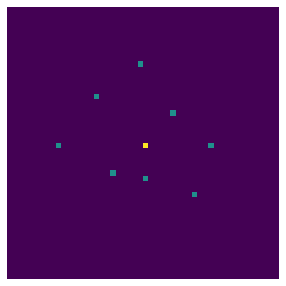

In [11]:
data = np.zeros((50, 50), dtype=int)
mid = int(data.shape[0]/2)
dis_factor = 5

for i in res:
    
    distance = i['dis']*dis_factor
    theta = i['ang'] * (np.pi/180)
    y = int(mid + distance * np.sin(theta)) 
    x = int(mid + distance * np.cos(theta))
    data[x, y] = 1

data[mid, mid] = 2
f = plt.figure(figsize=(5, 5)), plt.axis('off'), plt.imshow(data.T)

### Cloud points

(<AxesSubplot:>,
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x1d203ecee80>)

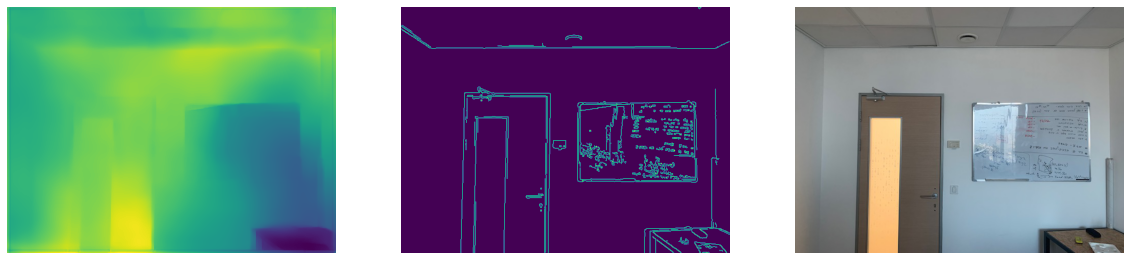

In [121]:
o_img=np.array(Image.open(str('./images/0.jpg')).resize((640,480)))
d_img=predict(model, o_img)
e_img=cv2.Canny(o_img,100,200)
    
f = plt.figure(figsize=(20, 5))
f.add_subplot(1, 3, 1), plt.axis('off'), plt.imshow(d_img)
f.add_subplot(1, 3, 2), plt.axis('off'), plt.imshow(e_img)
f.add_subplot(1, 3, 3), plt.axis('off'), plt.imshow(o_img)

In [123]:
x, y = np.nonzero(e_img)
z = np.ones((len(x),), dtype=np.int8)

fig = px.scatter_3d(x = x, y = y, z = z, height=500)
fig.update_traces(marker=dict(size=1, line=dict(width=1,color='black')))